In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *
from fastai.vision.models.unet import DynamicUnet
import pandas as pd

from bpho import *

/home/fredmonroe/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
datasetname = 'combo_001'
data_path = Path('.')
datasets = data_path/'datasets'
datasources = data_path/'data'
dataset = datasets/datasetname

hr_tifs = dataset/'hr'
lr_tifs = dataset/'lr'
lr_up_tifs = dataset/'lr_up'

hr_multi_tifs = dataset/'hr_5'
lr_up_multi_tifs = dataset/'lr_up_5'

mname = 'combo'
model_dir = 'models'

In [3]:
torch.cuda.set_device(1)

In [4]:
# code to build the multi-img files - shoudl be moved int build_combo

if False:
    fns = list(hr_tifs.glob('**/*.tif'))

    items = []
    movies = set()
    for fn in progress_bar(fns):
        parts = fn.stem.split('_')
        group = fn.relative_to(hr_tifs).parts[0]
        prefix = '_'.join(parts[:-1])
        frame = int(parts[-1])
        items.append(dict(fn=str(fn),prefix=prefix,group=group, frame=frame))
        movies.add((group, fn.parent/prefix))

    df = pd.DataFrame(items)

    wsize = 5
    batches = {}
    targets = {}
    for group, m in progress_bar(movies):
        m_prefix = m.stem
        movie_tifs = list(df.loc[df.prefix == m_prefix].sort_values('fn').fn.values)
        n_frames = len(movie_tifs)
        mid_idx = wsize//2
        for t in range(0, n_frames-wsize, wsize):
            #print(t, t+wsize)
            frame_batch = movie_tifs[t:(t+wsize)]
            if len(frame_batch) == wsize:
                bname = f'{m_prefix}_{t:06d}-{(t+wsize):06d}'
                target = movie_tifs[t+mid_idx]
                batches[bname] = (group, [Path(fn).name for fn in frame_batch])
                targets[bname] = (group, Path(target).name)

    hr_multi_tifs.mkdir(exist_ok=True)
    lr_up_multi_tifs.mkdir(exist_ok=True)
    for k in progress_bar(batches):
        group, batch = batches[k]
        _, target = targets[k]

        Path(hr_multi_tifs/group).mkdir(exist_ok=True)
        shutil.copy(hr_tifs/group/target, hr_multi_tifs/group/f'{k}.tif')

        Path(lr_up_multi_tifs/group).mkdir(exist_ok=True)
        multi_img_data = np.stack([np.array(PIL.Image.open(lr_up_tifs/group/fn)) for fn in batch])
        np.save(lr_up_multi_tifs/group/f'{k}.npy' ,multi_img_data)

In [5]:
def get_src(x_data, y_data_):
    def map_to_hr(x):
        hr_name = x.relative_to(x_data).with_suffix('.tif')
        return y_data_/hr_name
    
    src = (MultiImageImageList
            .from_folder(x_data, extensions=['.npy'])
            .split_by_rand_pct()
            .label_from_func(map_to_hr, convert_mode='L'))
    return src


def get_data(bs, size, x_data, y_data, max_zoom=1.1):
    src = get_src(x_data, y_data)
    #tfms = get_transforms(flip_vert=True, max_lighting=None, max_zoom=max_zoom)
    tfms = [[],[]]
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs))
    data.c = 3
    return data


def get_model(in_c, out_c, arch):
    body = nn.Sequential(*list(arch(c_in=in_c).children())[:-2])
    model = DynamicUnet(
        body, n_classes=out_c,
        blur=True, blur_final=True,
        self_attention=True, norm_type=NormType.Weight, 
        last_cross=True, bottle=True
    )
    return model

def xres_unet_learner(bs, img_size, arch, x_data, y_data, in_c=1, out_c=1, fp16=True):
    data = get_data(bs, img_size, x_data, y_data)
    model = get_model(in_c, out_c, arch)
    loss = F.mse_loss
    learn = Learner(data, model, loss_func=loss, metrics=sr_metrics, model_dir=model_dir) 
    if fp16: learn = learn.to_fp16(loss_scale=64)
    return learn

def do_fit(learn, save_name, lrs=slice(1e-3), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [6]:
bs = 4
img_size = 128
arch = xresnet34
learn = xres_unet_learner(bs, img_size, arch, lr_up_multi_tifs, hr_multi_tifs, in_c=5)
gc.collect()

0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


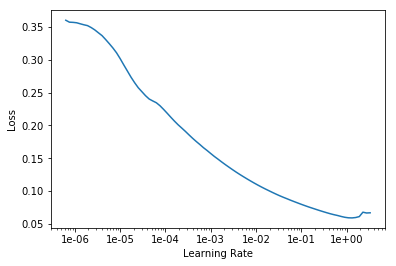

In [10]:
if True:
    learn.lr_find()
    learn.recorder.plot()

In [9]:
x,y = learn.data.one_batch()
x.shape, y.shape

(torch.Size([4, 5, 128, 128]), torch.Size([4, 1, 128, 128]))